In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.fft import fft2

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

load data (~10 min)

In [ ]:
mat_path = '/content/drive/MyDrive/1 Image Processing Project/Data/Matrix/T1_slice80'
mat = np.loadtxt(mat_path)

In [ ]:
mask_path = '/content/drive/MyDrive/1 Image Processing Project/Data/Mask/MNI152_T1_1mm_Brain_Mask.nii'

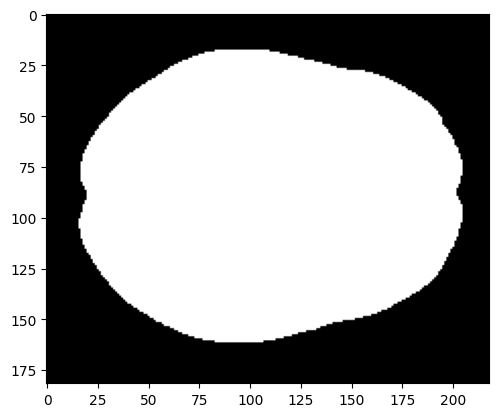

In [ ]:
brain_mask = nib.load(mask_path).get_fdata()[:,:,80].flatten()
plt.imshow(brain_mask.reshape(182,218), cmap = 'gray')


In [ ]:
masked_size = brain_mask[brain_mask != 0].shape[0]

In [ ]:
def PCA_recon_vs_original(mat, compression_factor):

  n = mat.shape[0]
  n_eigenvectors = int(np.round(n/compression_factor))
  pca = PCA(n_components=n_eigenvectors)
  mat_pca = pca.fit_transform(mat)
  recon_mat = pca.inverse_transform(mat_pca)

  return recon_mat, mat

In [ ]:
def display(array1, array2):

    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(182,218), cmap = 'gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Original')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(182, 218), cmap = 'gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Reconstructed')

    plt.show()

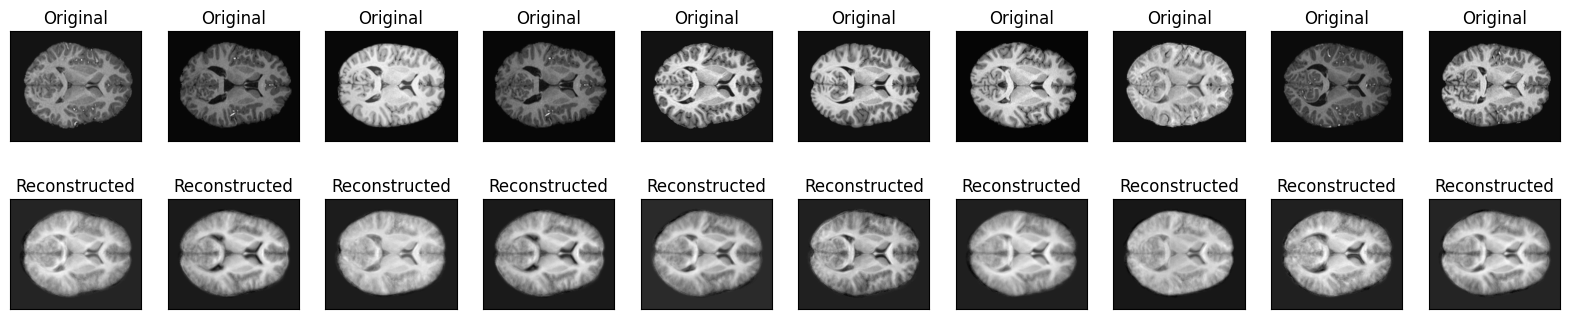

In [ ]:
a, b = PCA_recon_vs_original(mat, 10)
display(b, a) # display reconstruction with a 10:1 compression ratio

In [ ]:
def RMS_real_with_recon(mat, compression_factor):

  n = mat.shape[0]
  recon_mat, flat_mat = PCA_recon_vs_original(mat, compression_factor)

  # we are only interested in comparing voxels that are within the brain
  # so we remove the voxels that have a mask value of 0

  nonzero_mat, nonzero_recon_mat = np.zeros((n, masked_size)), np.zeros((n, masked_size))
  for i in range(n):
    nonzero_recon_mat[i] = recon_mat[i][brain_mask != 0]
    nonzero_mat[i] = flat_mat[i][brain_mask != 0]

  rms_arr = np.sqrt(((nonzero_mat - nonzero_recon_mat)**2).mean(axis=1))

  return pd.DataFrame(rms_arr, columns = ['RMSE'])


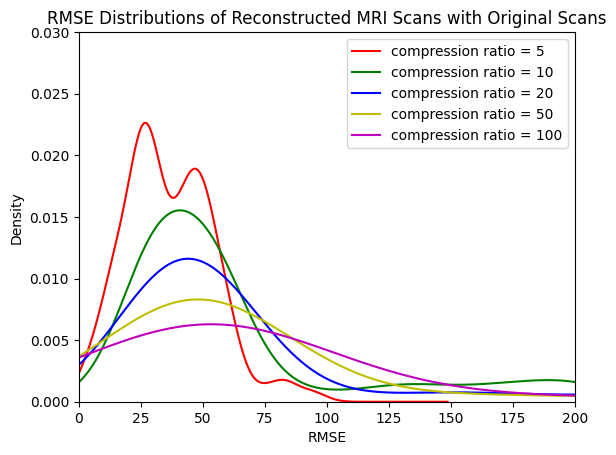

In [ ]:
comp_list = [5, 10, 20, 50, 100]
str_list = ['compression ratio = %s' %comp_list[i] for i in range(len(comp_list))]

df_list = [RMS_real_with_recon(mat, i) for i in comp_list]
clist = ['r', 'g', 'b', 'y', 'm']

fig, ax = plt.subplots()

for i in range(len(comp_list)):
  ax = df_list[i]['RMSE'].plot.density(color=clist[i], ax=ax)
  ax.set_xlim([0,200])
  ax.set_ylim([0,0.03])

ax.set_xlabel('RMSE')
ax.set_ylabel('Density')
ax.set_title('RMSE Distributions of Reconstructed MRI Scans with Original Scans')
ax.legend(str_list)
plt.show()


In [ ]:
def freqz(mat, compression_factor):

  n = mat.shape[0]
  n_eigenvectors = np.round(n/compression_factor)
  recon_mat, flat_mat = PCA_recon_vs_original(mat, n_eigenvectors)
  recon_fft2, mat_fft2 = np.zeros((n, 182, 218)), np.zeros((n, 182, 218))

  # calculate fft2 magnitude

  for i in range(len(data)):
    recon_fft2[i] = np.absolute(np.fft.fftshift(fft2(recon_mat[i].reshape(182, 218))))
    mat_fft2[i] = np.absolute(np.fft.fftshift(fft2(flat_mat[i].reshape(182, 218))))

  return recon_fft2, mat_fft2





In [ ]:
recon_freqz, original_freqz = freqz(mat, 10)

In [ ]:
# plot ff2 magnitude

idx = 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 15))
ax1.imshow(20*np.log(original_freqz[idx]))
ax1.set_xlabel('Original Image Spectrum')
ax2.imshow(20*np.log(recon_freqz[idx]))
ax2.set_xlabel('Reconstructed Image Spectrum')